In [2]:
%pylab inline
import numpy as np

import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

from matplotlib.colors import LogNorm
from statsmodels.nonparametric.kernel_density import KDEMultivariate

Populating the interactive namespace from numpy and matplotlib


In [93]:
class g:
    def __init__(self, r, phi, x0=0, y0=0, sigma=0.1):
        self.x0 = x0
        self.y0 = y0
        self.xf = 0
        self.yf = 0
        self.tf = 0
        self.r = r
        self.phi = phi
        self.sigma = sigma
        self.theta = 0
        self.theta_sampled = False
        self.compute_matrix()
        
    def set_theta(theta):
        self.theta = theta
        
    def compute_matrix(self):
        self.matrix = np.array([[np.cos(self.theta), -1*np.sin(self.theta), self.r*np.cos(self.phi)],
        [np.sin(self.theta), np.cos(self.theta), self.r*np.sin(self.phi)],[0,0,1]])
        
        self.xf = self.x0+self.matrix[0,-1]
        self.yf = self.y0+self.matrix[1,-1]
        self.tf = self.phi
        
    def sample_theta(self):
        self.theta = np.random.normal(scale=self.sigma)
        self.phi += self.theta
        self.compute_matrix()
        self.theta_sampled = True
    
    def propagate_backwards(self, x_endpoint, y_endpoint):
        if not self.theta_sampled: self.sample_theta()
        self.x0 = -1*self.r*np.cos(self.phi) + x_endpoint
        self.y0 = -1*self.r*np.sin(self.phi) + y_endpoint
        self.compute_matrix()

    def transform(self,g):
        return self.matrix*g
    
    def plot(self,c='k', alpha=0.2, linewidth=2):
        short = 0.1*self.r
        plot([self.x0,self.xf],[self.y0,self.yf],c=c,alpha=alpha,linewidth=linewidth)

    def add(self,g):
        self.x0 += g.x0+g.matrix[0,2]
        self.y0 += g.y0+g.matrix[1,2]
        self.phi += g.phi
        self.compute_matrix()

In [96]:
class chain:
    def __init__(self, r, phi, sigma=0.1, x0=0,y0=0, n_arms=6, plot=False, alpha = 0.2, linewidth = 2):
        self.r = r
        self.phi = phi
        self.sigma = sigma
        self.n_arms = n_arms
        self.links = []
        self.x0 = x0
        self.y0 = y0
        self.xf = NaN
        self.yf = NaN
        self.plot = plot
        
        #plotting
        self.alpha = alpha
        self.linewidth = linewidth
        
        self.coords = []
        
    def extend(self):
        
        self.links = [g(self.r,self.phi,x0 = self.x0, y0 = self.y0)]
        self.links[0].sample_theta()

        for link in range(self.n_arms-1):
            if self.plot: self.links[-1].plot()
            new_link = g(self.r,self.phi,sigma=self.sigma)
            new_link.sample_theta()
            new_link.add(self.links[-1])
            self.links.append(new_link)
            
        self.xf = self.links[-1].xf
        self.yf = self.links[-1].yf
        self.tf = self.links[-1].tf
        
        if self.plot:
            for link in self.links:
                link.plot(alpha=self.alpha)
                
        self.coords = [[link.xf,link.yf,link.tf] for link in self.links]
    
    def reverse(self):
        
        self.links=[g(self.r, np.pi*2, x0 = -1*self.r+self.x0, y0 = self.y0)]
        
        for rev_link in range(1,self.n_arms):

            #print(np.pi*2 - self.phi*rev_link)
            next_link_back = g(self.r,np.pi*2 - self.phi*rev_link, sigma=self.sigma)
            next_link_back.sample_theta()
            next_link_back.propagate_backwards(self.links[-1].x0, self.links[-1].y0)
            self.links.append(next_link_back) 
            
        if self.plot:
            for link in self.links:
                link.plot(alpha = self.alpha, linewidth = self.linewidth)
                
        self.xf = self.links[-1].x0
        self.yf = self.links[-1].y0
        self.tf = self.links[-1].tf
        self.coords = [[link.x0,link.y0,link.tf] for link in self.links]

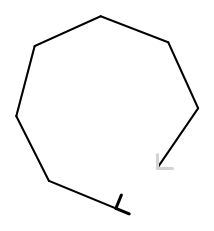

In [142]:
figure(figsize=(4,4))
u0=0.2
u=0.2

subplot(1,1,1,aspect='equal')
chn = chain(1, 2*np.pi/7, sigma=10**-1, n_arms=7, plot=True, alpha = 1)
chn.extend()

plot([chn.xf, chn.xf+u*np.cos(chn.tf)],
     [chn.yf, chn.yf+u*np.sin(chn.tf)],c='k')

plot([chn.xf, chn.xf+u*np.cos(chn.tf+np.pi/2)],
     [chn.yf, chn.yf+u*np.sin(chn.tf+np.pi/2)],c='k')

plot([0,0],[0,u0], color='#D3D3D3')
plot([0,u0],[0,0], color='#D3D3D3')

axis('off')
savefig('single_sample.pdf',transparent=True,bbox_inches='tight')

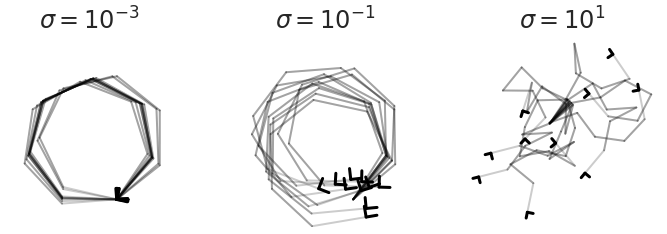

In [114]:
figure(figsize=(12,12))

u = 0.2
for i, log_sig in enumerate([-3,-1,1]):
    subplot(3,3,i+1,aspect='equal')
    x_for, y_for, t_for, x_rev, y_rev, t_rev=[], [], [], [], [], []

    if i!= 2:
        xlim([-2,1])
        ylim([-0.5,3])
    for j in range(10):
        title(r'$\sigma = 10^{%d}$' % log_sig)
        chain_test = chain(1, 2*np.pi/7, sigma=10**log_sig, n_arms=7, plot=True)
        chain_test.extend()
        x_for.append(chain_test.xf)
        y_for.append(chain_test.yf)
        t_for.append(chain_test.tf)
        plot([x_for[-1], x_for[-1]+u*np.cos(t_for[-1])],
             [y_for[-1], y_for[-1]+u*np.sin(t_for[-1])],c='k')
        
        plot([x_for[-1], x_for[-1]+u*np.cos(t_for[-1]+np.pi/2)],
             [y_for[-1], y_for[-1]+u*np.sin(t_for[-1]+np.pi/2)],c='k')
    axis('off')
    
savefig('example_naive_trajectories.pdf',transparent=True,bbox_inches='tight')

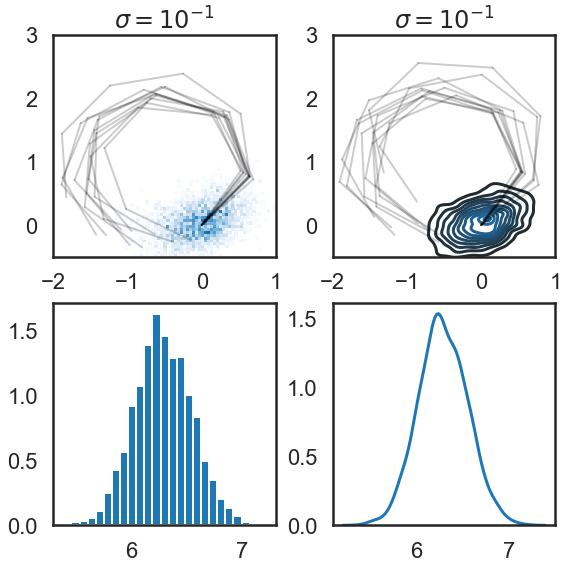

In [143]:
x_for, y_for, t_for, x_rev, y_rev, t_rev=[], [], [], [], [], []
figure(figsize=(8,8))

for j in range(3000):
    title(r'$\sigma = 10^{%d}$' % -1)
    chain_test = chain(1, 2*np.pi/7, sigma=10**-1, n_arms=7, plot=False)
    chain_test.extend()
    x_for.append(chain_test.xf)
    y_for.append(chain_test.yf)
    t_for.append(chain_test.tf)

subplot(2,2,1)

for j in range(10):
    title(r'$\sigma = 10^{%d}$' % -1)
    chain_test = chain(1, 2*np.pi/7, sigma=10**-1, n_arms=7, plot=True, alpha=0.001)
    chain_test.extend()

hist2d(x_for, y_for, bins=75, range=[[-2,1],[-0.5,3]],cmin=1, zorder=0,cmap='Blues')
xlim([-2,1])
ylim([-0.5,3])    

subplot(2,2,2)

for j in range(10):
    title(r'$\sigma = 10^{%d}$' % -1)
    chain_test = chain(1, 2*np.pi/7, sigma=10**-1, n_arms=7, plot=True, alpha=0.001)
    chain_test.extend()
    
sns.kdeplot(x_for,y_for)
xlim([-2,1])
ylim([-0.5,3])

t_for = np.array(t_for)
subplot(2,2,3)
hist(t_for, bins = 25, density=True)

subplot(2,2,4)
sns.kdeplot(t_for)

tight_layout()
savefig('figure_kde_vs_hist.pdf',transparent=True,bbox_inches='tight')

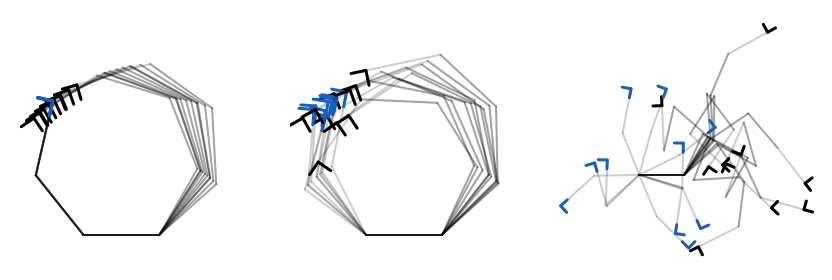

In [144]:
x_for, y_for, t_for, x_rev, y_rev, t_rev=[], [], [], [], [],[]
figure(figsize=(12,4))

u = 0.2
for i, log_sig in enumerate([-3,-1,1]):
    subplot(1,3,i+1,aspect='equal')
    if i!= 2:
        xlim([-2,1])
        ylim([-0.5,3])
    for i in range(10):
        chain_test = chain(1, 2*np.pi/7, sigma=10**log_sig, n_arms=4, plot=True)
        chain_test.extend()
        x_for.append(chain_test.xf)
        y_for.append(chain_test.yf)
        t_for.append(chain_test.tf)
        
        chain_test = chain(1, 2*np.pi/7, sigma=10**log_sig, n_arms=3, plot=True)
        chain_test.reverse()
        x_rev.append(chain_test.xf)
        y_rev.append(chain_test.yf)
        t_rev.append(chain_test.tf)

        plot([x_for[-1], x_for[-1]+u*np.cos(t_for[-1])],
             [y_for[-1], y_for[-1]+u*np.sin(t_for[-1])],c='k')
        
        plot([x_for[-1], x_for[-1]+u*np.cos(t_for[-1]+np.pi/2)],
             [y_for[-1], y_for[-1]+u*np.sin(t_for[-1]+np.pi/2)],c='k')
        
        plot([x_rev[-1], x_rev[-1]+u*np.cos(t_rev[-1])],
             [y_rev[-1], y_rev[-1]+u*np.sin(t_rev[-1])],c='#1560bd')
     
        plot([x_rev[-1], x_rev[-1]+u*np.cos(t_rev[-1]-np.pi/2)],
             [y_rev[-1], y_rev[-1]+u*np.sin(t_rev[-1]-np.pi/2)],c='#1560bd')
    axis('off')
tight_layout()
savefig('example_grid_trajectories.pdf',transparent=True,bbox_inches='tight')


In [ ]:
subplot(3,3,4)

for j in range(10):
    title(r'$\sigma = 10^{%d}$' % -1)
    chain_test = chain(1, 2*np.pi/7, sigma=10**-1, n_arms=7, plot=True, alpha=0.001)
    chain_test.extend()
#     x_for.append(chain_test.xf)
#     y_for.append(chain_test.yf)
#     t_for.append(chain_test.tf)

sns.kdeplot(x_for,y_for)
xlim([-2,1])
ylim([-0.5,3])

subplot(3,3,5)

for j in range(10):
    title(r'$\sigma = 10^{%d}$' % -1)
    chain_test = chain(1, 2*np.pi/7, sigma=10**-1, n_arms=7, plot=True, alpha=0.001)
    chain_test.extend()
#     x_for.append(chain_test.xf)
#     y_for.append(chain_test.yf)
#     t_for.append(chain_test.tf)
    
hist2d(x_for, y_for, bins=100, range=[[-2,1],[-0.5,3]],cmin=1, zorder=0,cmap='Blues')
xlim([-2,1])
ylim([-0.5,3])


# Visualize 8 links, forward and back

/Users/hwayment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/Users/hwayment/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/hwayment/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/hwayment/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/hwayment/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/Users/hwayment/miniconda3/lib/python3.7/site-packages/mat

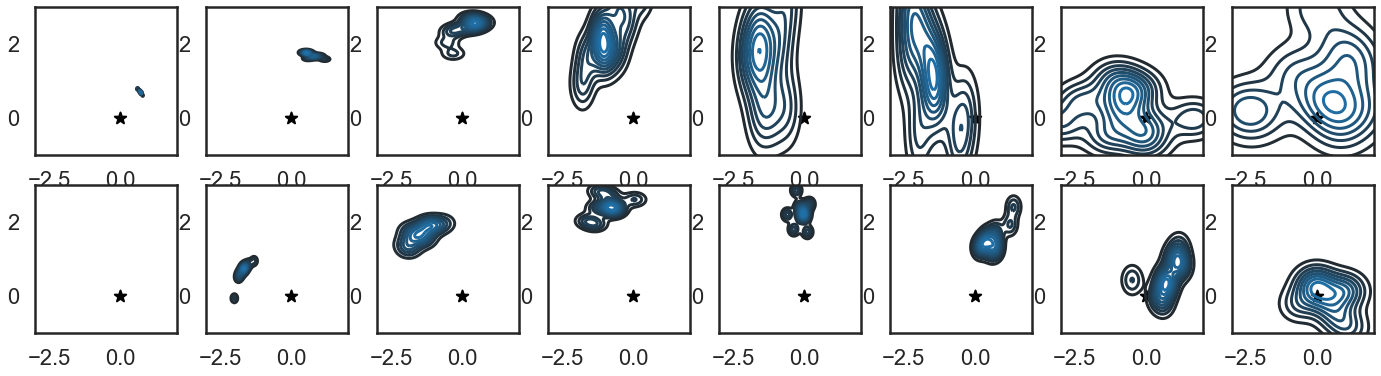

In [4]:
figure(figsize=(24,6))
n_mc_iters = 10

for n_arms in range(1,9):
    x_for, y_for, t_for, x_rev, y_rev, t_rev =[],[], [], [],[], []

    for i in range(n_mc_iters):
        chain_test = chain(1, np.pi/4, sigma=0.3, n_arms=n_arms)
        chain_test.extend()
        x_for.append(chain_test.xf)
        y_for.append(chain_test.yf)
        t_for.append(chain_test.tf)

        chain_test = chain(1, np.pi/4, sigma=0.3, n_arms=n_arms)
        chain_test.reverse()
        x_rev.append(chain_test.xf)
        y_rev.append(chain_test.yf)
        t_rev.append(chain_test.tf)
        
    subplot(2,8,n_arms)
    sns.kdeplot(x_for, y_for,c='b')
    xlim([-3,2])
    ylim([-1,3])
    scatter([0],[0],c='k',marker='*')

    subplot(2,8,n_arms+8)
    xlim([-3,2])
    ylim([-1,3])
    scatter([0],[0],c='k',marker='*')

    sns.kdeplot(x_rev, y_rev,c='g')

# generate reverse-path kde densities

In [68]:
n_mc_iters = 20
n_arms = 8
coords = []

for i in range(n_mc_iters):
    chain_test = chain(1, np.pi/4, sigma=0.1, n_arms=n_arms)
    chain_test.reverse()
    coords.append(chain_test.coords)

coords=np.array(coords)
coords = np.swapaxes(coords,0,1)

kde_mdls = [KDEMultivariate(data=x, var_type='ccc', bw='silverman') for x in coords]

# Importance-sample the whole way back

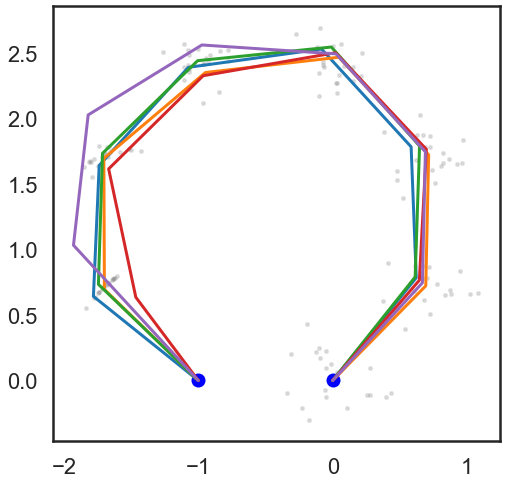

In [77]:
figure(figsize=(8,8))

for sample in coords:
    scatter(sample[:,0],sample[:,1],s=10, c='grey',alpha=0.2)
    
scatter(0,0,c='b')
scatter(-1,0,c='b')
for k in range(5):
    next_x, next_y, next_t=0,0,0
    x,y=[0],[0]
    for link in [-1,-2,-3,-4,-5,-6]:
        p_reverse=[]
        samples_xf, samples_yf, samples_tf=[],[],[]
        for i in range(10):
            chain_test = chain(1, next_t+np.pi/4, sigma=1, n_arms=1, x0=next_x, y0=next_y)
            chain_test.extend()
            samples_xf.append(chain_test.xf)
            samples_yf.append(chain_test.yf)
            samples_tf.append(chain_test.tf)
            p_reverse.append(kde_mdls[link].pdf([chain_test.xf,chain_test.yf, chain_test.tf]))
        winner = np.argmax(p_reverse)
        #print(np.max(p_reverse))
        #scatter(samples_xf,samples_yf)
        
        next_x, next_y, next_t = samples_xf[winner], samples_yf[winner],samples_tf[winner]
        x.append(next_x)
        y.append(next_y)

    x.append(-1)
    y.append(0)
    plot(x,y)

# Take some number from what was already back-sampled:

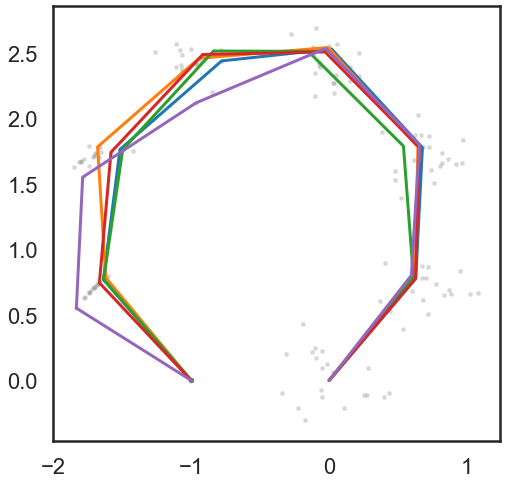

In [76]:
figure(figsize=(8,8))

for sample in coords:
    scatter(sample[:,0],sample[:,1],s=10, c='grey',alpha=0.2)
# scatter(0,0,c='b')
# scatter(-1,0,c='b')
for k in range(5):
    next_x, next_y, next_t=0,0,0
    x,y=[0],[0]
    for link in [-1,-2,-3]:
        p_reverse=[]
        samples_xf, samples_yf, samples_tf=[],[],[]
        for i in range(10):
            chain_test = chain(1, next_t+np.pi/4, sigma=0.1, n_arms=1, x0=next_x, y0=next_y)
            chain_test.extend()
            samples_xf.append(chain_test.xf)
            samples_yf.append(chain_test.yf)
            samples_tf.append(chain_test.tf)
            p_reverse.append(kde_mdls[link].pdf([chain_test.xf,chain_test.yf, chain_test.tf]))
        winner = np.argmax(p_reverse)
        #print(np.max(p_reverse))
        #scatter(samples_xf,samples_yf)
        
        next_x, next_y, next_t = samples_xf[winner], samples_yf[winner],samples_tf[winner]
        x.append(next_x)
        y.append(next_y)

    for for_link in [3,2,1,0]:
        x.append(coords[for_link,k,0])
        y.append(coords[for_link,k,1])
    plot(x,y)